In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./Unipol_dataset_lab3.csv")
data_f_dist = data[data["total_distance"] > 0.0]#distances equal to 0 are an outlier
print(data_f_dist.shape)
data_f_dist = data_f_dist[~((data_f_dist["total_distance"] <0.1) & (data_f_dist["road"] == "A"))]#removes 50ish trips



(1249353, 7)


In [2]:
data_f_dist.shape[0]

1249058

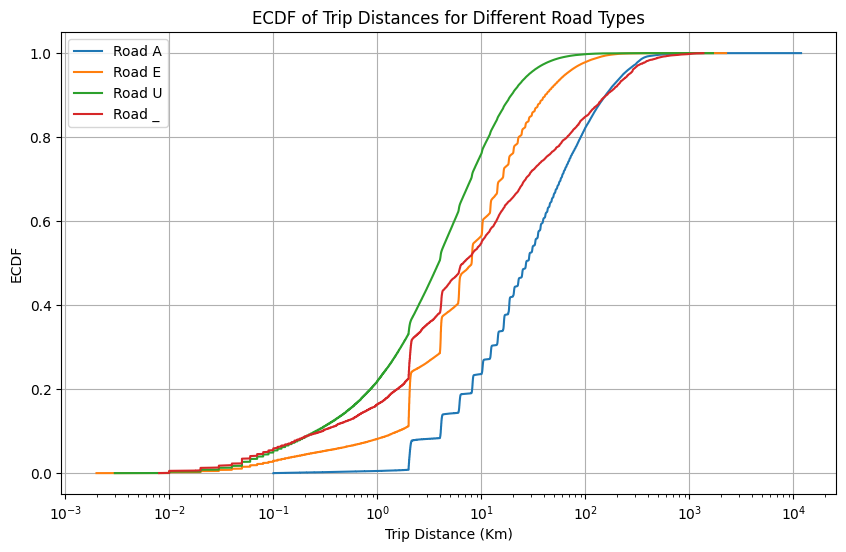

"\nFrom the ECDF plot:\n- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).\n- Road type 'U' primarily has shorter trips, with most distances under 2 km.\n- The step-like patterns in the ECDF indicate discrete trip distances.\n- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.\n"

In [3]:
grouped = data_f_dist.groupby("road")
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

for road, group in grouped:
    x, y = ecdf(group["total_distance"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Distance (Km)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Distances for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()


"""
From the ECDF plot:
- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).
- Road type 'U' primarily has shorter trips, with most distances under 2 km.
- The step-like patterns in the ECDF indicate discrete trip distances.
- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.
"""

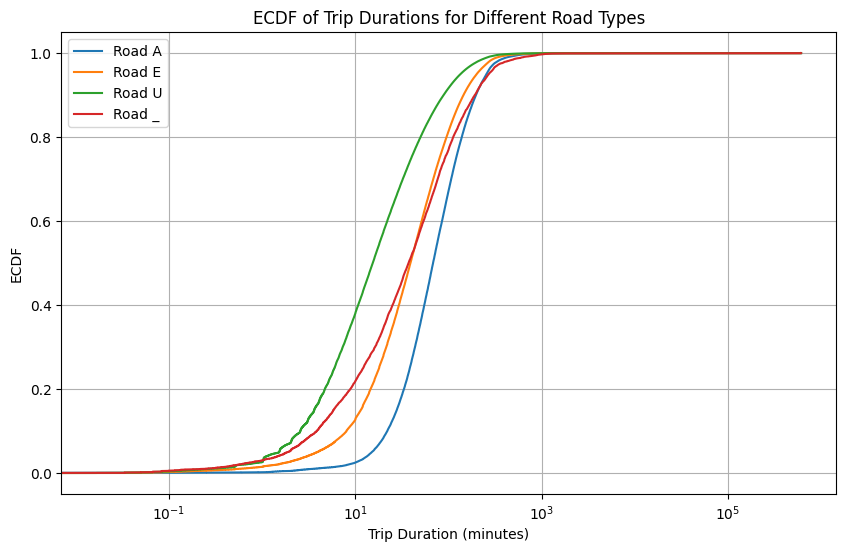

In [4]:

data_f_dist["start_time"] = pd.to_datetime(data_f_dist["start_time"])
data_f_dist["stop_time"] = pd.to_datetime(data_f_dist["stop_time"])
data_f_dist["trip_duration"] = (data_f_dist["stop_time"] - data_f_dist["start_time"]).dt.total_seconds() / 60.0 
grouped = data_f_dist.groupby("road")

plt.figure(figsize=(10, 6))
for road, group in grouped:
    x, y = ecdf(group["trip_duration"])
    plt.semilogx(x, y, label=f"Road {road}")

# Add labels, legend, and title
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Durations for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

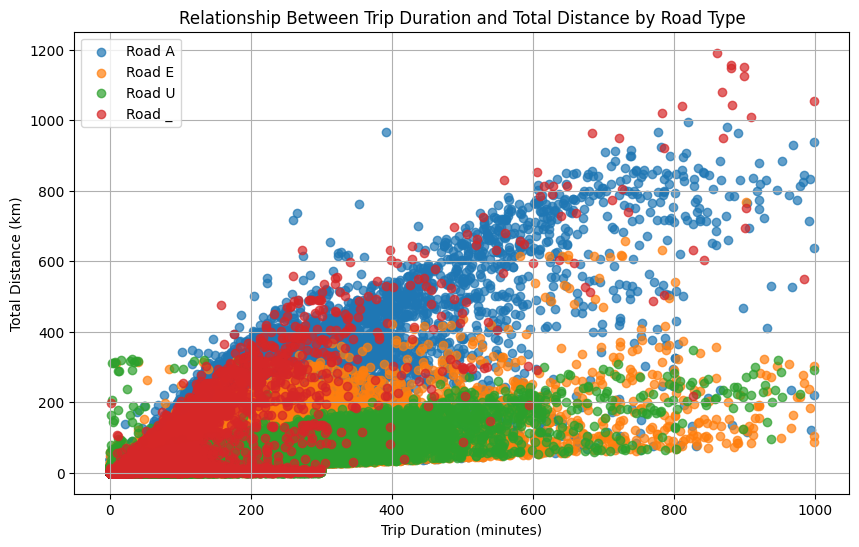

In [5]:
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 10) & (data_f_dist["trip_duration"] > 600))]#removes 100ish trips
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 5) & (data_f_dist["trip_duration"] > 300))]#removes 50ish trips

#data = data[data["trip_duration"] < 2880]#remove duration grate than 48 hours
data_f_dist_avg_dur = data_f_dist_avg[data_f_dist_avg['trip_duration'] < 1000]#remove duration grate than 24 hours 
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist_avg_dur.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()

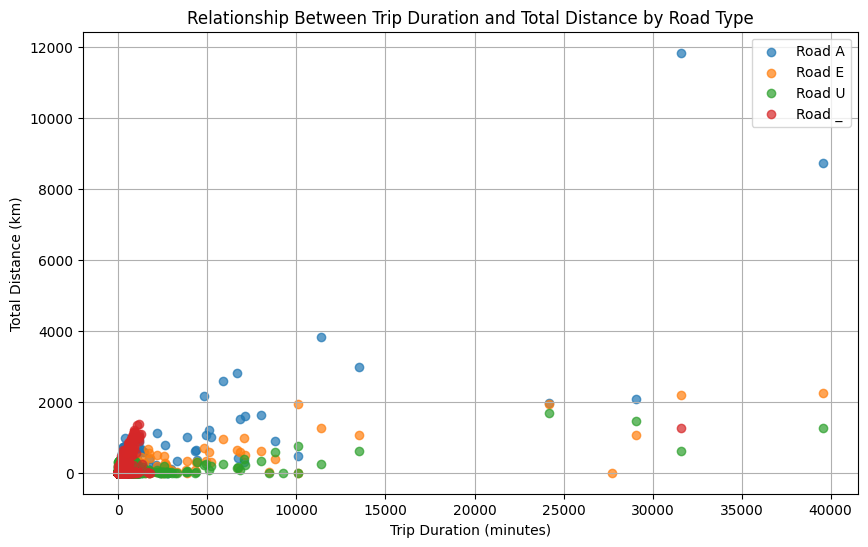

In [6]:
data_f_dist = data_f_dist[data_f_dist['trip_duration'] < 100000]#remove duration grate than 24 hours
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
nonFiltered_count = data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips before filtering: {nonFiltered_count}")

Number of trips before filtering: 966000


In [8]:
fil_dist_avg_dur_count = data_f_dist_avg_dur.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips after filtering for average distance and duration: {fil_dist_avg_dur_count}")

Number of trips after filtering for average distance and duration: 827886


In [9]:
data_f_dist.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]


828117

# Task 1

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./Unipol_dataset_lab3.csv")
data = data[data["total_distance"] > 0.0]
data = data[~((data["total_distance"] <0.1) & (data["road"] == "A"))]

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0 

data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 10) & (data["trip_duration"] > 600))]#removes 100ish trips
data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips
data = data[data['trip_duration'] < 1200]#remove duration grate than 1200 minutes, 20 hours

#Number of trips before filtering: 966000 
print(data.shape[0], data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0])

1243568 827889


In [11]:


data["date"] = data["start_time"].dt.date
aggregated = data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = aggregated["total_driving_time"] / (24 * 60) * 100  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated['day_type'] = aggregated['day_of_week'].apply(lambda x: 'workday' if x < 5 else 'weekend/holiday')

stats = aggregated.groupby(['vehicle_id', 'day_type']).agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

stats.describe()

vehicle_id number_of_trips                            \
                              mean       median          std   
count  1993.000000     1993.000000  1993.000000  1990.000000   
mean    500.113899       13.594017    13.253889     5.886605   
std     288.993781       14.899269    15.270273     5.961715   
min       1.000000        1.000000     1.000000     0.000000   
25%     250.000000        7.065217     6.500000     3.160159   
50%     499.000000       11.288889    11.000000     4.683589   
75%     751.000000       17.000000    17.000000     7.065721   
max    1000.000000      412.833333   422.500000   159.748792   

      total_travel_distance                           utilization_percentage  \
                       mean       median          std                   mean   
count           1993.000000  1993.000000  1990.000000            1993.000000   
mean             345.678380   340.515997   176.161064              68.212871   
std              158.870941   182.716961   102.640283              25.925898   
min                0.047500     0.050000     0.007071               0.193287   
25%              248.826111   234.470000   105.249495              52.657022   
50%              308.608889   302.635000   150.857304              68.072857   
75%              418.651000   429.730000   221.605952              84.152443   
max              960.639773  1204.620000   712.520596             178.483410   

                                 
            median          std  
count  1993.000000  1990.000000  
mean     68.383332    31.180851  
std      29.781183    12.732440  
min       0.170718     0.057273  
25%      51.225694    22.302934  
50%      68.793403    29.925457  
75%      86.982639    38.743430  
max     173.126157    99.959494

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

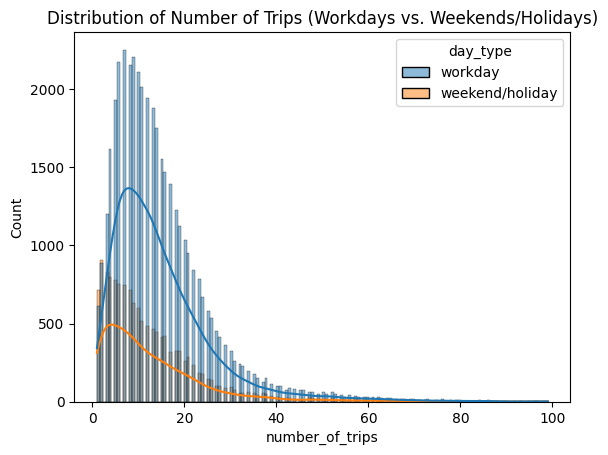

In [12]:
import seaborn as sns
hist_data = aggregated[aggregated['number_of_trips'] < 100]
sns.histplot(data=hist_data, x='number_of_trips', hue='day_type', kde=True)
plt.title('Distribution of Number of Trips (Workdays vs. Weekends/Holidays)')
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

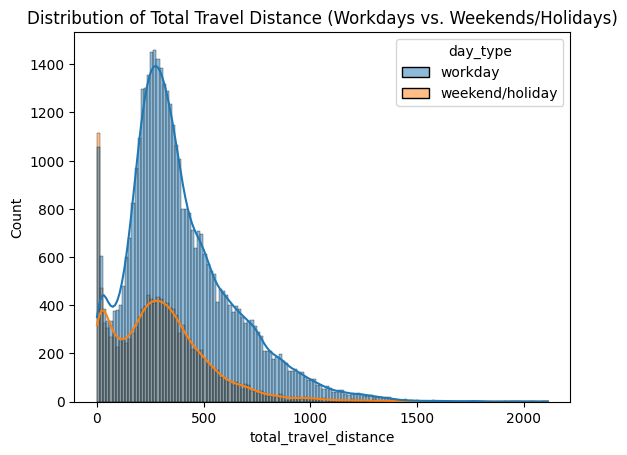

In [13]:
sns.histplot(data=hist_data, x='total_travel_distance', hue='day_type', kde=True)
plt.title('Distribution of Total Travel Distance (Workdays vs. Weekends/Holidays)')
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

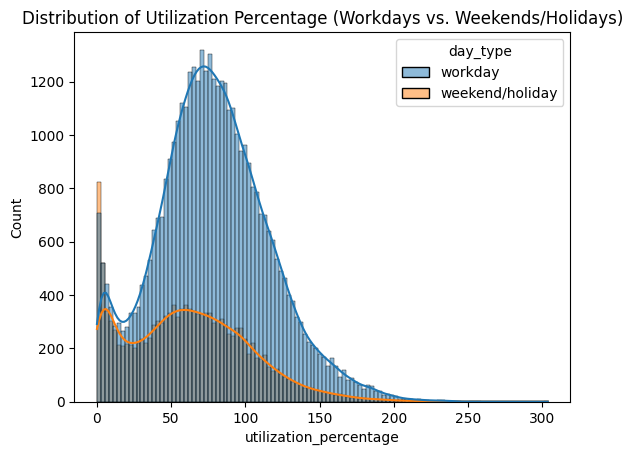

In [14]:
sns.histplot(data=hist_data, x='utilization_percentage', hue='day_type', kde=True)
plt.title('Distribution of Utilization Percentage (Workdays vs. Weekends/Holidays)')
plt.show()

In [15]:
from sklearn.cluster import KMeans

# Example: cluster vehicles based on average # of trips/day, avg distance/day, fraction of trips on road 'A', etc.
vehicle_agg = (
    data.groupby("vehicle_id")
    .agg(
        avg_trips_per_day=("trip_id", lambda x: x.nunique() / ( (data["date"].max() - data["date"].min()).days + 1 )),
        avg_distance_per_day=("total_distance", lambda x: x.sum()   / ( (data["date"].max() - data["date"].min()).days + 1 )),
        fraction_road_A=("road", lambda x: np.mean(x == "A")),
        fraction_road_U=("road", lambda x: np.mean(x == "U")),
        fraction_road_E=("road", lambda x: np.mean(x == "E")),
    )
)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
vehicle_agg["cluster"] = kmeans.fit_predict(vehicle_agg)

print(vehicle_agg.head(10))


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


            avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
vehicle_id                                                             
1                    1.055670             54.675518         0.173256   
2                    0.585567             69.839629         0.256781   
3                    0.777320             72.234994         0.231190   
4                    0.981443             30.013979         0.075472   
5                    0.595876             71.547485         0.208413   
6                    1.952577             56.204386         0.123804   
7                    2.820619             29.781278         0.137626   
8                    0.785567             36.102412         0.051237   
9                    1.082474             34.237505         0.167832   
10                   1.672165             29.729938         0.096261   

            fraction_road_U  fraction_road_E  cluster  
vehicle_id                                             
1                  0.35

In [16]:
print("Cluster centers:")
print(kmeans.cluster_centers_)
cluster_profiles = vehicle_agg.groupby("cluster").mean()
print(cluster_profiles)


Cluster centers:
[[ 1.91624666 34.19045633  0.10672655  0.63981633  0.24962052]
 [ 1.01077048 74.63873117  0.21973982  0.35081449  0.39465651]
 [ 1.41251359 53.82338527  0.19102547  0.42058809  0.36887921]]
         avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
cluster                                                             
0                 1.916247             34.190456         0.106727   
1                 1.010770             74.638731         0.219740   
2                 1.412514             53.823385         0.191025   

         fraction_road_U  fraction_road_E  
cluster                                    
0               0.639816         0.249621  
1               0.350814         0.394657  
2               0.420588         0.368879  


In [17]:
cluster_names = {
    0: "Urban Short Trips",
    1: "Highway Long Distances",
    2: "Frequent Commuters"
}




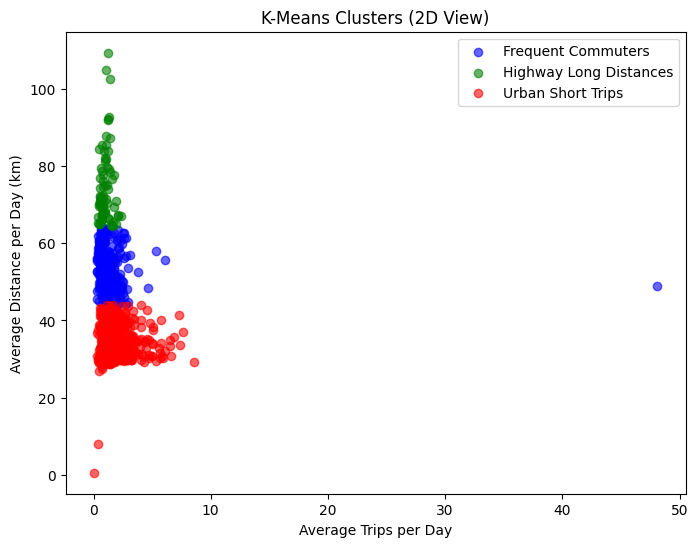

In [18]:
#Plot the clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
colors = {0: "red", 1: "green", 2: "blue"}  # or any color map

for cluster_id in vehicle_agg["cluster"].unique():
    subset = vehicle_agg[vehicle_agg["cluster"] == cluster_id]
    ax.scatter(
        subset["avg_trips_per_day"],
        subset["avg_distance_per_day"],
        c=colors[cluster_id],
        label=cluster_names[cluster_id],
        alpha=0.6
    )

ax.set_xlabel("Average Trips per Day")
ax.set_ylabel("Average Distance per Day (km)")
ax.set_title("K-Means Clusters (2D View)")
ax.legend()
plt.show()


# Task 2

1. Tesla model 3 range: 420km
2. BMW iX xDrive40 range: 360km
3. Citroen e-C3  range: 260km



Evaluation Metrics
1. Percentage of Feasible Trips 
2. Energy Consumption per 100 km
3. Charging time

In [19]:
import json

cars = {
  "cars": {
    "Tesla Model 3": {
      "cost": 40990, #EUR Germany
      "range_km": 420,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 137, #Wh/km
        "charging_time": 6
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 201,
        "total_power_kw": 208,
        "total_torque_nm": 420,
        "drive": "Rear"
      },
      "battery": {
        "nominal_capacity_kwh": 60.0,
        "useable_capacity_kwh": 57.5,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "6h15m",
          "charge_speed_kmh": 68
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 170,
          "charge_power_10_80_kw_dc": 108,
          "charge_time_min": 24,
          "charge_speed_kmh": 730
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 149,
        "highway_cold_weather_wh_km": 189,
        "combined_cold_weather_wh_km": 167,
        "city_mild_weather_wh_km": 93,
        "highway_mild_weather_wh_km": 142,
        "combined_mild_weather_wh_km": 116
      }
    },
    "BMW iX xDrive40": {
      "cost": 77300, #EUR Germany
      "range_km": 360,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 200, #Wh/km
        "charging_time": 8
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 200,
        "total_power_kw": 240,
        "total_torque_nm": 630,
        "drive": "All-Wheel Drive"
      },
      "battery": {
        "nominal_capacity_kwh": 76.6,
        "useable_capacity_kwh": 71,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "8h",
          "charge_speed_kmh": 45
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 150,
          "charge_power_10_80_kw_dc": 110,
          "charge_time_min": 31,
          "charge_speed_kmh": 580
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 180,
        "highway_cold_weather_wh_km": 220,
        "combined_cold_weather_wh_km": 200,
        "city_mild_weather_wh_km": 140,
        "highway_mild_weather_wh_km": 180,
        "combined_mild_weather_wh_km": 160
      }
    },
    "Citroen e-C3": {
      "cost": 23300, #EUR Germany
      "range_km": 260,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 150, #Wh/km
        "charging_time": 7
      },
      "performance": {
        "acceleration_0_100_kmh": "9.7 sec",
        "top_speed_kmh": 150,
        "total_power_kw": 100,
        "total_torque_nm": 260,
        "drive": "Front"
      },
      "battery": {
        "nominal_capacity_kwh": 50,
        "useable_capacity_kwh": 45,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 7.4,
          "charge_time_h": "7h",
          "charge_speed_kmh": 37
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 100,
          "charge_power_10_80_kw_dc": 75,
          "charge_time_min": 30,
          "charge_speed_kmh": 520
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 160,
        "highway_cold_weather_wh_km": 200,
        "combined_cold_weather_wh_km": 180,
        "city_mild_weather_wh_km": 120,
        "highway_mild_weather_wh_km": 160,
        "combined_mild_weather_wh_km": 140
      }
    }
  }
}



task 3

+-------------------+       +-------------------+       +-------------------+
| Define EVs & Trips| ----> | Replicate Trips   | ----> | Generate Report   |
+-------------------+       +-------------------+       +-------------------+
                               |
                               v
                        +-------------------+
                        | Simulate Consumption |
                        +-------------------+

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])

data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0
weather = "mild" #mild or cold
charging_type = "home_destination" #fast_charging or home_destination
vehicle_data = data.groupby("vehicle_id")
price_fast_charging = 0.5 #EUR per kWh
price_home_charging = 0.15 #EUR per kWh

results_list = []  # Initialize results_list outside the loop for each car model

for car, specs in cars["cars"].items():
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]   #  kWh 
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id, trips in vehicle_data:
        remaining_kwh = battery_capacity
        total_charge_time = 0
        distance_vehicle = []
        energy_vehicle = []
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0  
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds()/60 #minutes 
                if time_since_last_stop > 20:
                    
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60 #max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time= time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time
                    
            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  #  Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))
    
        feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100 if total_trips > 0 else 0
        charge_time = np.mean(total_charge_time) 
        hours, minutes = divmod(charge_time, 60)  # hours and minutes
        avg_kwh = np.mean(kwh_after_trip)
        energy_consumed_100km = np.mean(energy_consumed)/np.mean(distance_trips)*1000
        results_list.append({
            "vehicle_id": vehicle_id,
            "car": car,
            "total_trips": total_trips,
            "feasible_percentage": feasible_percentage,
            "average_charge_time": f"{int(hours)} hours and {int(minutes)} minutes",
            "average_soc_after_trip": avg_kwh,
            "soc_percentage": avg_kwh / battery_capacity * 100,
            "energy_consumption_per_100km": energy_consumed_100km,
            "average_energy_cost": np.mean(energy_vehicles) * price_home_charging,
            "car_cost": specs['cost']
        
    })

results_df = pd.DataFrame(results_list)
print(results_df)

      vehicle_id            car  total_trips  feasible_percentage  \
0              1  Tesla Model 3          860            81.395349   
1              2  Tesla Model 3         1413            66.737438   
2              3  Tesla Model 3         2144            51.492537   
3              4  Tesla Model 3         2833            63.289799   
4              5  Tesla Model 3         3356            60.846246   
...          ...            ...          ...                  ...   
2992         996   Citroen e-C3      1239076            74.012571   
2993         997   Citroen e-C3      1239643            73.987995   
2994         998   Citroen e-C3      1240762            73.983407   
2995         999   Citroen e-C3      1242783            74.024267   
2996        1000   Citroen e-C3      1243568            74.020399   

         average_charge_time  average_soc_after_trip  soc_percentage  \
0     4 hours and 39 minutes               33.926647       59.002864   
1     4 hours and 33 minute

In [34]:
merged_df = results_df.merge(
    vehicle_agg[["cluster"]], 
    how="left",
    left_on="vehicle_id",
    right_index=True
)

merged_df.head(10)


,vehicle_id,car,total_trips,feasible_percentage,average_charge_time,average_soc_after_trip,soc_percentage,energy_consumption_per_100km,average_energy_cost,car_cost,cluster
0,1,Tesla Model 3,860,81.395349,4 hours and 39 minutes,33.926647,59.002864,130.078523,413.361047,40990,2
1,2,Tesla Model 3,1413,66.737438,4 hours and 33 minutes,29.958914,52.102459,130.564182,365.036264,40990,1
2,3,Tesla Model 3,2144,51.492537,3 hours and 53 minutes,24.684699,42.929911,129.451431,309.210012,40990,1
3,4,Tesla Model 3,2833,63.289799,2 hours and 15 minutes,30.998126,53.909784,123.485913,288.628899,40990,0
4,5,Tesla Model 3,3356,60.846246,4 hours and 29 minutes,30.863149,53.675042,124.467387,288.683668,40990,1
5,6,Tesla Model 3,5133,74.089227,4 hours and 42 minutes,35.897087,62.429716,121.975400,318.081154,40990,2
6,7,Tesla Model 3,6826,80.515675,2 hours and 15 minutes,39.302401,68.352003,119.697898,304.598291,40990,0
7,8,Tesla Model 3,7392,82.007576,2 hours and 51 minutes,39.938270,69.457860,118.291657,302.228217,40990,0
8,9,Tesla Model 3,8250,83.587879,3 hours and 2 minutes,40.469858,70.382361,118.938479,301.123993,40990,0
9,10,Tesla Model 3,9507,85.757863,2 hours and 26 minutes,40.884948,71.104257,118.492292,295.623060,40990,0


In [ ]:
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return 0  
    hours, minutes = map(int, time_str.replace(" hours", "").replace(" minutes", "").split(" and "))
    return hours + minutes / 60

merged_df["avg_charging_time_hrs"] = merged_df["average_charge_time"].apply(convert_time_to_hours)


results_with_clusters = merged_df.groupby(["cluster", "car","vehicle_id"]).agg({
    "feasible_percentage": "mean",
    "avg_charging_time_hrs": "mean",
    "total_trips": "mean",
    "average_soc_after_trip": "mean",
    "energy_consumption_per_100km": "mean",
    "average_energy_cost": "mean",
    "car_cost": "mean",
}).reset_index()

print(results_with_clusters)



      cluster              car  vehicle_id  feasible_percentage  \
0           0  BMW iX xDrive40           4            55.735969   
1           0  BMW iX xDrive40           7            76.443012   
2           0  BMW iX xDrive40           8            78.246753   
3           0  BMW iX xDrive40           9            80.024242   
4           0  BMW iX xDrive40          10            82.665404   
...       ...              ...         ...                  ...   
2992        2    Tesla Model 3         987            89.735816   
2993        2    Tesla Model 3         992            89.788224   
2994        2    Tesla Model 3         994            89.829293   
2995        2    Tesla Model 3         995            89.813960   
2996        2    Tesla Model 3         997            89.788189   

      avg_charging_time_hrs  total_trips  average_soc_after_trip  \
0                  3.250000       2833.0               35.494205   
1                  3.233333       6826.0               43.8

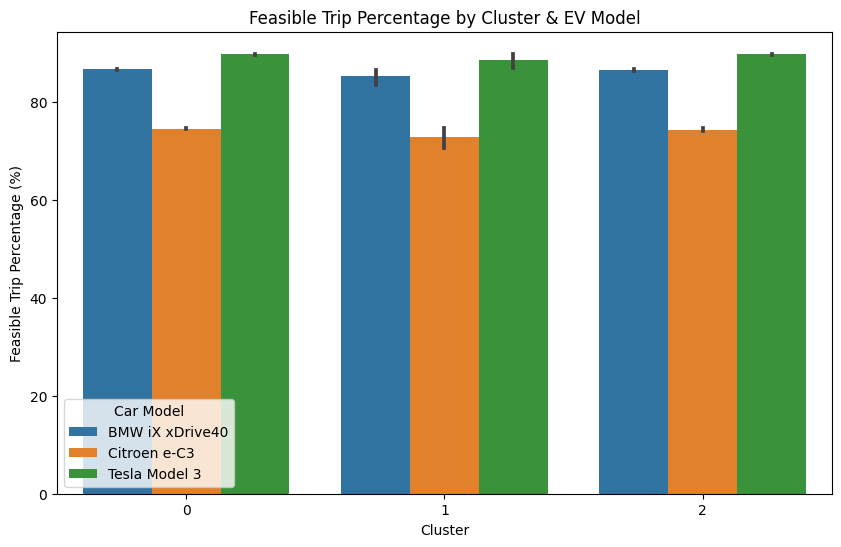

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_with_clusters, 
    x="cluster", 
    y="feasible_percentage", 
    hue="car"
)
plt.title("Feasible Trip Percentage by Cluster & EV Model")
plt.xlabel("Cluster")
plt.ylabel("Feasible Trip Percentage (%)")
plt.legend(title="Car Model")
plt.show()


In [49]:
def calculate_compatibility_score(results_df, cars, weights_perf=(0.4, 0.3, 0.3), weights_cost=(0.6, 0.4), alpha=0.7):
    """
    Calculate the compatibility score for each EV model and vehicle_id based on performance and costs.
    
    Args:
    - results_df: DataFrame containing the results of the simulation (metrics per EV model and vehicle).
    - cars: Dictionary containing the EV purchase costs.
    - weights_perf: Weights for performance metrics (feasible trips %, charge time, energy consumption).
    - weights_cost: Weights for cost metrics (energy cost, purchase cost).
    - alpha: Weight for performance vs cost trade-off (0.7 means 70% performance, 30% cost).
    
    Returns:
    - DataFrame with compatibility scores for each vehicle and EV model.
    """
    
    results_df["feasible_percentage"] = results_df["feasible_percentage"] / 100  
    results_df["Normalized Charge Time"] = 1 - (results_df["avg_charging_time_hrs"] / results_df["avg_charging_time_hrs"].max())
    results_df["Normalized Energy Consumption"] = 1 - (results_df["energy_consumption_per_100km"] / results_df["energy_consumption_per_100km"].max())
    

    results_df["Performance Score"] = (
        weights_perf[0] * results_df["feasible_percentage"] +
        weights_perf[1] * results_df["Normalized Charge Time"] +
        weights_perf[2] * results_df["Normalized Energy Consumption"]
    )
    

    purchase_costs = {car: specs["cost"] for car, specs in cars["cars"].items()}
    results_df["car_cost"] = results_df["car"].map(purchase_costs)
    
    
    results_df["Normalized Energy Cost"] = 1 - (results_df["average_energy_cost"] / results_df["average_energy_cost"].max())
    results_df["Normalized Purchase Cost"] = 1 - (results_df["car_cost"] / results_df["car_cost"].max())
    
    
    results_df["Cost Score"] = (
        weights_cost[0] * results_df["Normalized Energy Cost"] +
        weights_cost[1] * results_df["Normalized Purchase Cost"]
    )
    
    
    results_df["Compatibility Score"] = (
        alpha * results_df["Performance Score"] +
        (1 - alpha) * results_df["Cost Score"]
    )
    
    
    sorted_results = results_df.sort_values(by=["vehicle_id", "Compatibility Score"], ascending=[True, False])
    
    return sorted_results


In [50]:
# Calculate compatibility scores
sorted_results = calculate_compatibility_score(results_with_clusters, cars, alpha=0.7)

sorted_results.groupby("vehicle_id").head(1)


,cluster,car,vehicle_id,feasible_percentage,avg_charging_time_hrs,total_trips,average_soc_after_trip,energy_consumption_per_100km,average_energy_cost,car_cost,Normalized Charge Time,Normalized Energy Consumption,Performance Score,Normalized Energy Cost,Normalized Purchase Cost,Cost Score,Compatibility Score
2722,2,Tesla Model 3,1,0.813953,4.650000,860.0,33.926647,130.078523,413.361047,40990,0.497297,0.238229,0.546239,0.199623,0.469728,0.307665,0.474667
2096,1,Tesla Model 3,2,0.667374,4.550000,1413.0,29.958914,130.564182,365.036264,40990,0.508108,0.235385,0.489998,0.293193,0.469728,0.363807,0.452140
2097,1,Tesla Model 3,3,0.514925,3.883333,2144.0,24.684699,129.451431,309.210012,40990,0.580180,0.241901,0.452595,0.401287,0.469728,0.428664,0.445415
1296,0,Tesla Model 3,4,0.632898,2.250000,2833.0,30.998126,123.485913,288.628899,40990,0.756757,0.276837,0.563237,0.441138,0.469728,0.452574,0.530038
2098,1,Tesla Model 3,5,0.608462,4.483333,3356.0,30.863149,124.467387,288.683668,40990,0.515315,0.271089,0.479306,0.441032,0.469728,0.452510,0.471267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,0,Tesla Model 3,996,0.898084,2.716667,1239076.0,41.400336,117.545544,297.193320,40990,0.706306,0.311625,0.664613,0.424555,0.469728,0.442624,0.598016
2996,2,Tesla Model 3,997,0.897882,3.166667,1239643.0,41.393445,117.554709,297.153364,40990,0.657658,0.311571,0.649921,0.424632,0.469728,0.442671,0.587746
1941,0,Tesla Model 3,998,0.897910,3.416667,1240762.0,41.386599,117.559054,297.180493,40990,0.630631,0.311546,0.641817,0.424579,0.469728,0.442639,0.582063
1942,0,Tesla Model 3,999,0.898076,2.400000,1242783.0,41.401069,117.545322,297.124618,40990,0.740541,0.311626,0.674880,0.424688,0.469728,0.442704,0.605227


     vehicle_id  Compatibility Score            car  cluster
0             1             0.474667  Tesla Model 3        2
1             2             0.452140  Tesla Model 3        1
2             3             0.445415  Tesla Model 3        1
3             4             0.530038  Tesla Model 3        0
4             5             0.471267  Tesla Model 3        1
..          ...                  ...            ...      ...
994         996             0.598016  Tesla Model 3        0
995         997             0.587746  Tesla Model 3        2
996         998             0.582063  Tesla Model 3        0
997         999             0.605227  Tesla Model 3        0
998        1000             0.606771  Tesla Model 3        0

[999 rows x 4 columns]


C:\Users\nepim\AppData\Local\Temp\ipykernel_11364\1965652363.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_ev_df = sorted_results.groupby("vehicle_id").apply(lambda x: x.nlargest(1, "Compatibility Score")).reset_index(drop=True)


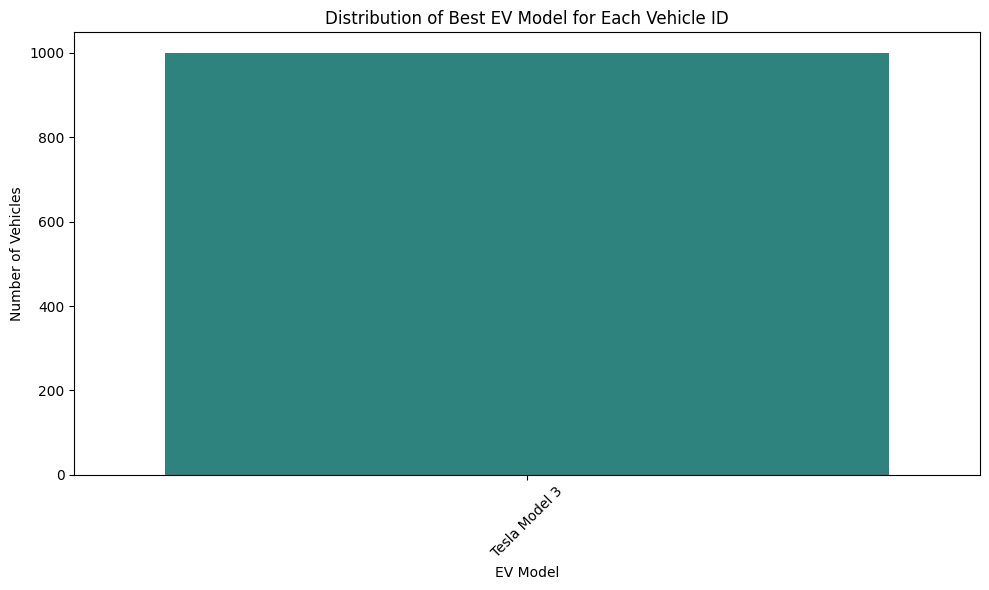

In [ ]:

def best_ev_model_per_vehicle(sorted_results):
    best_ev_df = sorted_results.groupby("vehicle_id").apply(lambda x: x.nlargest(1, "Compatibility Score")).reset_index(drop=True)
    best_ev_df = best_ev_df[["vehicle_id", "Compatibility Score", "car", "cluster"]]
    return best_ev_df

# Plot the distribution of the best EV models
def plot_best_ev_models(best_ev_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    sns.countplot(data=best_ev_df, x="car", order=best_ev_df["car"].value_counts().index, palette="viridis")
    plt.title("Distribution of Best EV Model for Each Vehicle ID")
    plt.xlabel("EV Model")
    plt.ylabel("Number of Vehicles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Apply the functions
best_ev_df = best_ev_model_per_vehicle(sorted_results)
print(best_ev_df)
plot_best_ev_models(best_ev_df)


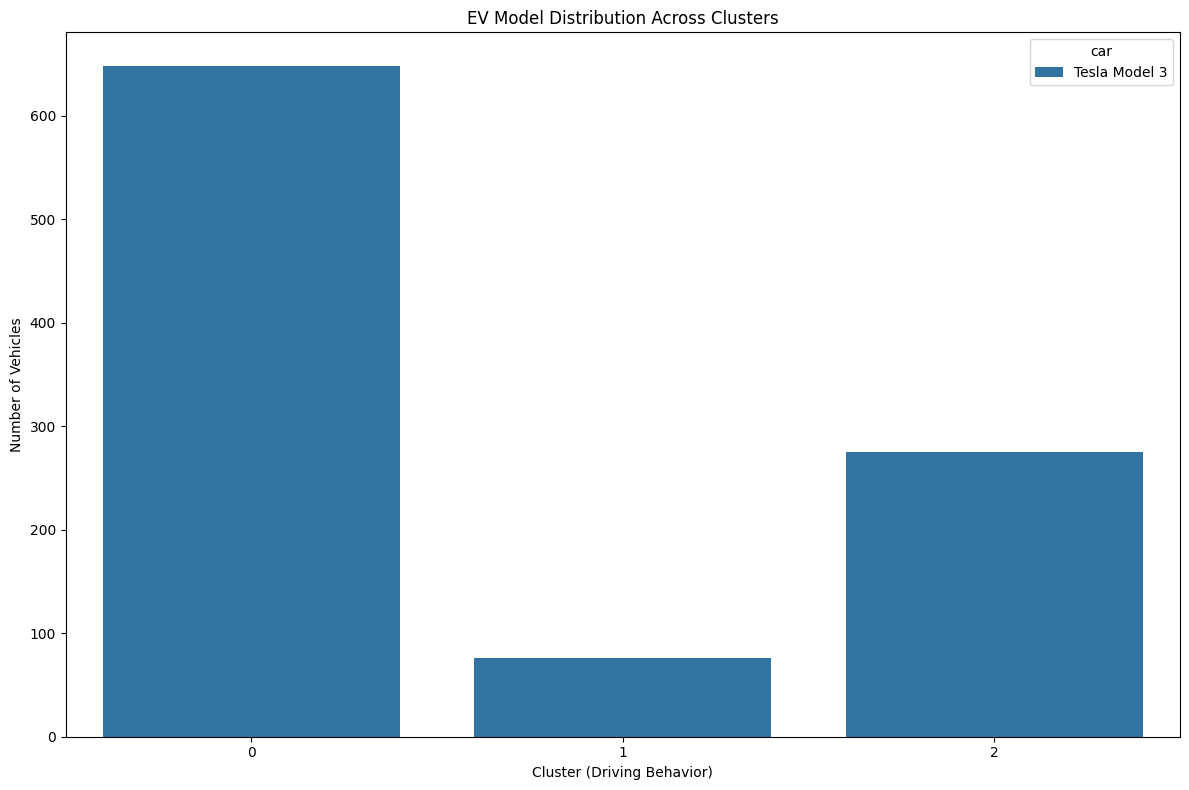

In [64]:

cluster_ev_summary = best_ev_df.groupby(["cluster", "car"]).size().reset_index(name="Count")


def plot_cluster_ev_summary(cluster_ev_summary):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    sns.barplot(data=cluster_ev_summary, x="cluster", y="Count", hue="car", palette="tab10")
    plt.title("EV Model Distribution Across Clusters")
    plt.xlabel("Cluster (Driving Behavior)")
    plt.ylabel("Number of Vehicles")
    plt.tight_layout()
    plt.show()

plot_cluster_ev_summary(cluster_ev_summary)


## Task 6

In [67]:
import random
import pandas as pd


def is_nighttime(dt, night_start=22, night_end=6):
    hour = dt.hour
    return (hour >= night_start) or (hour < night_end)

def simulate_all_ev_models_with_refined_policy_debug(vehicle_data, cars, min_parking_time=40):
    results = []  # Store results for each EV

    for car, specs in cars["cars"].items():
        print(f"Running simulation for {car}...\n{'-' * 60}")

        for vehicle_id, trips in vehicle_data:
            battery_capacity = specs["battery"]["useable_capacity_kwh"]  # in kWh
            price_home_charging = 0.15  # EUR per kWh (night)
            price_fast_charging = 0.50  # EUR per kWh (day)

            soc = battery_capacity  # Start with full charge
            total_cost = 0  # Cost tracker
            feasible_trips = 0
            unfeasible_trips = 0
            total_energy_consumed = 0  # kWh
            total_trip_distance = 0  # km
            total_charge_time = 0  # hours
            charging_events = 0  # Count complete charging sessions
            soc_after_trips = []
            last_stop = None

            for trip_index, trip in trips.iterrows():
                trip_start = trip["start_time"]
                trip_stop = trip["stop_time"]
                distance_km = trip["total_distance"]
                parking_time_minutes = (trip_start - last_stop).total_seconds() / 60 if last_stop else 0

                # Charge if idle time is above the threshold
                if last_stop is not None and parking_time_minutes >= min_parking_time:
                    is_night = is_nighttime(last_stop)
                    if is_night:
                        charge_power = specs["charging"]["home_destination"]["charge_power_kw_ac"]
                        charge_cost = price_home_charging
                    else:
                        road_type = trip["road"]
                        charge_power = 0
                        if road_type == "A" and random.random() < 0.8:
                            charge_power = specs["charging"]["fast_charging"]["charge_power_max_kw_dc"]
                            charge_cost = price_fast_charging
                        elif road_type == "U" and random.random() < 0.5:
                            charge_power = specs["charging"]["fast_charging"]["charge_power_max_kw_dc"]
                            charge_cost = price_fast_charging
                        elif road_type == "E" and random.random() < 0.3:
                            charge_power = specs["charging"]["fast_charging"]["charge_power_max_kw_dc"]
                            charge_cost = price_fast_charging

                    hours_to_charge = parking_time_minutes / 60
                    energy_to_charge = charge_power * hours_to_charge

                    if soc + energy_to_charge > battery_capacity:
                        energy_to_charge = battery_capacity - soc

                    if energy_to_charge > 0:
                        soc += energy_to_charge
                        total_cost += energy_to_charge * charge_cost
                        total_charge_time += hours_to_charge
                        charging_events += 1  

                # Attempt the trip
                consumption_rate = specs["evaluation_metrics"]["energy_consumption_per_100_km"] / 1000  # kWh/km
                energy_needed = distance_km * consumption_rate

                if energy_needed > soc:
                    unfeasible_trips += 1
                    soc = 0  # Vehicle arrives with 0 SoC
                    total_energy_consumed += energy_needed
                else:
                    soc -= energy_needed
                    feasible_trips += 1
                    total_trip_distance += distance_km
                    total_energy_consumed += energy_needed

                soc_after_trips.append(soc)
                last_stop = trip_stop

            # Calculate final metrics for the vehicle
            feasible_percentage = (feasible_trips / len(trips)) * 100 if len(trips) > 0 else 0
            num_days = trips["start_time"].dt.date.nunique()  # Count unique days
            avg_charge_time = total_charge_time / charging_events if charging_events > 0 else 0  # Average charge time per session
            avg_charge_time_per_day = total_charge_time / num_days if num_days > 0 else 0  # Average charge time per day
            hours_session, minutes_session = divmod(avg_charge_time * 60, 60)  # For average charge time (session)
            hours_day, minutes_day = divmod(avg_charge_time_per_day * 60, 60)  # For average charge time (per day)
            avg_soc_after_trip = sum(soc_after_trips) / len(soc_after_trips) if len(soc_after_trips) > 0 else 0
            avg_energy_consumed_per_100km = (total_energy_consumed / total_trip_distance) * 1000 if total_trip_distance > 0 else 0

            results.append({
                "car": car,
                "vehicle_id": vehicle_id,
                "feasible_percentage": feasible_percentage,
                "avg_charging_time_hrs": f"{int(hours_session)}h {int(minutes_session)}m",
                "Average Charge Time per Day (hours:minutes)": f"{int(hours_day)}h {int(minutes_day)}m",
                "average_soc_after_trip": avg_soc_after_trip,
                "energy_consumption_per_100_km": avg_energy_consumed_per_100km,
                "average_energy_cost": total_cost,
                "Total Charging Events": charging_events,
                "car_cost": specs["cost"]
            })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df



In [68]:
vehicle_data = data.groupby("vehicle_id")
results_df_t6 = simulate_all_ev_models_with_refined_policy_debug(vehicle_data, cars)

Running simulation for Tesla Model 3...
------------------------------------------------------------
Running simulation for BMW iX xDrive40...
------------------------------------------------------------
Running simulation for Citroen e-C3...
------------------------------------------------------------
                car  vehicle_id  feasible_percentage avg_charging_time_hrs  \
0     Tesla Model 3           1            70.116279                7h 48m   
1     Tesla Model 3           2            68.716094                5h 30m   
2     Tesla Model 3           3            48.153215                4h 17m   
3     Tesla Model 3           4            95.355588                 6h 7m   
4     Tesla Model 3           5            64.053537                5h 27m   
...             ...         ...                  ...                   ...   
2992   Citroen e-C3         996            70.537262                6h 43m   
2993   Citroen e-C3         997            45.679012                3h 4

In [69]:
merged_df_t6 = results_df_t6.merge(
    vehicle_agg[["cluster"]],  
    how="left",
    left_on="vehicle_id",
    right_index=True
)


merged_df_t6.head(10)


,car,vehicle_id,feasible_percentage,avg_charging_time_hrs,Average Charge Time per Day (hours:minutes),average_soc_after_trip,energy_consumption_per_100_km,average_energy_cost,Total Charging Events,car_cost,cluster
0,Tesla Model 3,1,70.116279,7h 48m,10h 24m,25.694533,215.284705,1208.721693,76,40990,2
1,Tesla Model 3,2,68.716094,5h 30m,11h 54m,23.909222,282.655690,1212.415823,108,40990,1
2,Tesla Model 3,3,48.153215,4h 17m,7h 21m,13.870398,455.641367,941.866155,89,40990,1
3,Tesla Model 3,4,95.355588,6h 7m,11h 21m,40.299734,145.433831,634.165523,115,40990,0
4,Tesla Model 3,5,64.053537,5h 27m,9h 21m,23.471148,349.749686,920.030154,91,40990,1
5,Tesla Model 3,6,92.909398,72h 51m,173h 55m,35.316483,150.667664,1326.329957,148,40990,2
6,Tesla Model 3,7,96.515062,5h 38m,8h 8m,39.104507,142.174475,796.075680,88,40990,0
7,Tesla Model 3,8,85.865724,5h 18m,6h 33m,31.231754,166.371083,988.177772,74,40990,0
8,Tesla Model 3,9,96.270396,5h 22m,13h 3m,42.386164,151.674588,844.140902,148,40990,0
9,Tesla Model 3,10,83.373111,9h 18m,13h 6m,29.006700,161.895148,791.248051,76,40990,0


In [76]:
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return 0  # Handle NaN values
    if isinstance(time_str, str):
        hours, minutes = map(int, time_str.replace("h", "").replace("m", "").split(" "))
        return hours + minutes / 60
    return time_str  


merged_df_t6["avg_charging_time_hrs"] = merged_df_t6["avg_charging_time_hrs"].apply(convert_time_to_hours)


results_with_clusters_t6 = merged_df_t6.groupby(["cluster", "car","vehicle_id"]).agg({
    "feasible_percentage": "mean",
    "avg_charging_time_hrs": "mean",
    #"total_trips": "mean",
    "average_soc_after_trip": "mean",
    "energy_consumption_per_100_km": "mean",
    "average_energy_cost": "mean",
    "car_cost": "mean",
}).reset_index()

print(results_with_clusters_t6)

      cluster              car  vehicle_id  feasible_percentage  \
0           0  BMW iX xDrive40           4            92.452830   
1           0  BMW iX xDrive40           7            94.034259   
2           0  BMW iX xDrive40           8            81.272085   
3           0  BMW iX xDrive40           9            91.258741   
4           0  BMW iX xDrive40          10            87.509944   
...       ...              ...         ...                  ...   
2992        2    Tesla Model 3         987            67.227979   
2993        2    Tesla Model 3         992            91.921824   
2994        2    Tesla Model 3         994            78.794693   
2995        2    Tesla Model 3         995            67.983075   
2996        2    Tesla Model 3         997            56.613757   

      avg_charging_time_hrs  average_soc_after_trip  \
0                  6.350000               47.820290   
1                  6.000000               45.893240   
2                  5.950000   

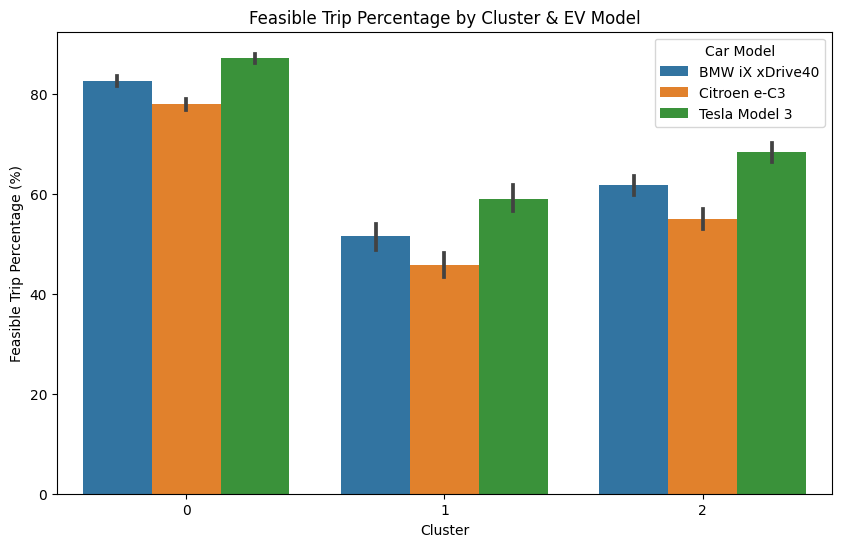

In [77]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_with_clusters_t6, 
    x="cluster", 
    y="feasible_percentage", 
    hue="car"
)
plt.title("Feasible Trip Percentage by Cluster & EV Model")
plt.xlabel("Cluster")
plt.ylabel("Feasible Trip Percentage (%)")
plt.legend(title="Car Model")
plt.show()

In [79]:
sorted_results_t6 = calculate_compatibility_score(results_with_clusters_t6.rename(columns={'energy_consumption_per_100_km': 'energy_consumption_per_100km'}), cars, alpha=0.7)

# Display top EV model per vehicle
sorted_results_t6.groupby("vehicle_id").head(1)

,cluster,car,vehicle_id,feasible_percentage,avg_charging_time_hrs,average_soc_after_trip,energy_consumption_per_100km,average_energy_cost,car_cost,Normalized Charge Time,Normalized Energy Consumption,Performance Score,Normalized Energy Cost,Normalized Purchase Cost,Cost Score,Compatibility Score
2447,2,Citroen e-C3,1,0.006314,6.033333,17.534056,335.952548,1094.286552,23300,0.984414,0.919456,0.573687,0.550467,0.698577,0.609711,0.584494
2020,1,Citroen e-C3,2,0.005063,5.616667,14.272384,536.939503,1101.558689,23300,0.985490,0.871270,0.559054,0.547479,0.698577,0.607918,0.573713
2021,1,Citroen e-C3,3,0.004172,3.300000,8.745740,633.781825,845.469664,23300,0.991475,0.848053,0.553527,0.652681,0.698577,0.671039,0.588781
648,0,Citroen e-C3,4,0.009115,5.583333,28.843146,169.772622,703.774650,23300,0.985577,0.959297,0.587108,0.710889,0.698577,0.705964,0.622765
2022,1,Citroen e-C3,5,0.005602,6.200000,15.741148,624.856483,926.551817,23300,0.983983,0.850192,0.552494,0.619372,0.698577,0.651054,0.582062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,0,Citroen e-C3,996,0.007054,6.716667,18.633944,418.335788,500.305497,23300,0.982649,0.899705,0.567528,0.794474,0.698577,0.756115,0.624104
2721,2,Citroen e-C3,997,0.004568,3.816667,12.570400,706.649974,459.652883,23300,0.990140,0.830583,0.548044,0.811174,0.698577,0.766135,0.613471
1293,0,Citroen e-C3,998,0.007221,7.100000,16.082455,259.333938,819.623658,23300,0.981658,0.937825,0.578733,0.663298,0.698577,0.677410,0.608336
1294,0,Citroen e-C3,999,0.008595,4.866667,25.460345,177.870365,881.492264,23300,0.987428,0.957356,0.586873,0.637883,0.698577,0.662160,0.609459


     vehicle_id  Compatibility Score           car  cluster
0             1             0.584494  Citroen e-C3        2
1             2             0.573713  Citroen e-C3        1
2             3             0.588781  Citroen e-C3        1
3             4             0.622765  Citroen e-C3        0
4             5             0.582062  Citroen e-C3        1
..          ...                  ...           ...      ...
994         996             0.624104  Citroen e-C3        0
995         997             0.613471  Citroen e-C3        2
996         998             0.608336  Citroen e-C3        0
997         999             0.609459  Citroen e-C3        0
998        1000             0.639018  Citroen e-C3        0

[999 rows x 4 columns]


C:\Users\nepim\AppData\Local\Temp\ipykernel_11364\1965652363.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_ev_df = sorted_results.groupby("vehicle_id").apply(lambda x: x.nlargest(1, "Compatibility Score")).reset_index(drop=True)


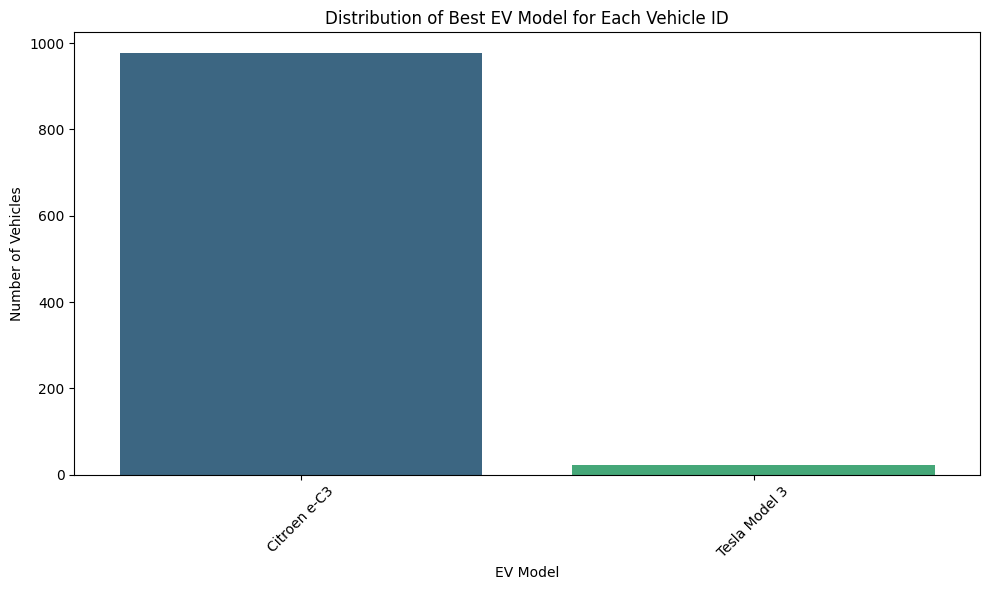

In [80]:
best_ev_df_t6 = best_ev_model_per_vehicle(sorted_results_t6)
print(best_ev_df_t6)
plot_best_ev_models(best_ev_df_t6)

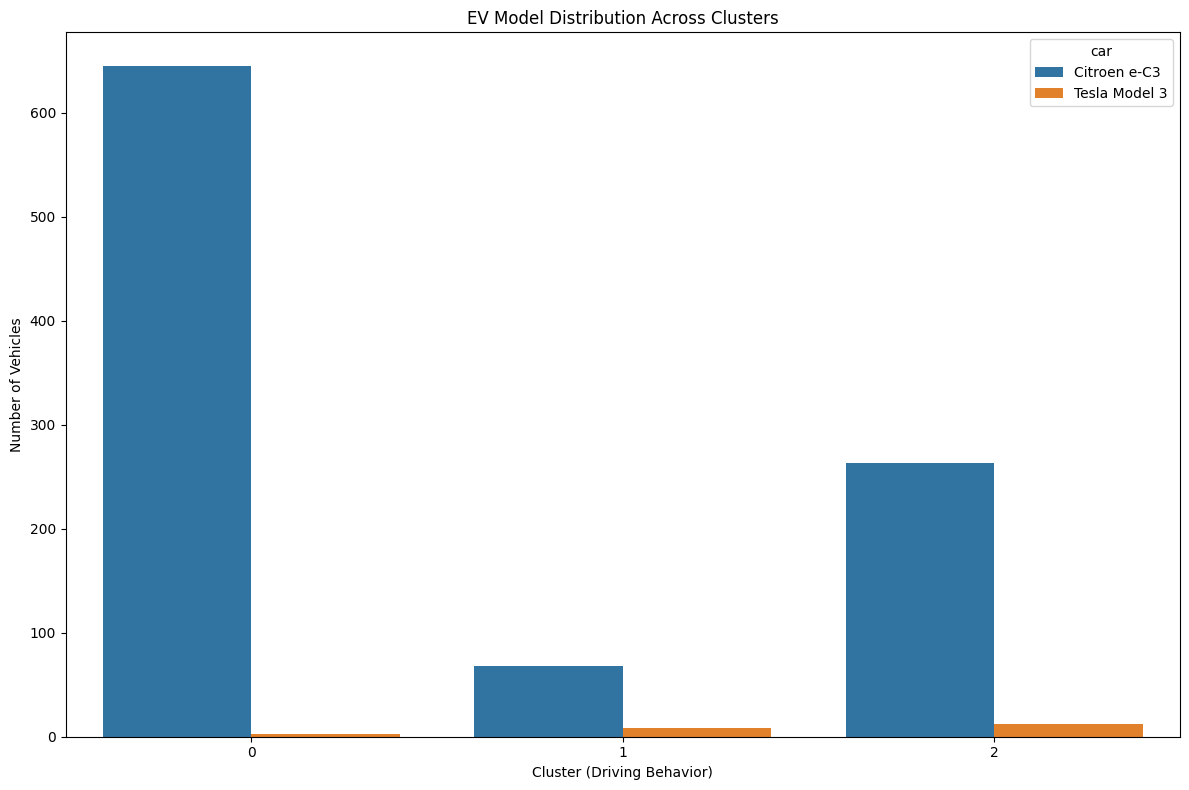

In [81]:
cluster_ev_summary_t6 = best_ev_df_t6.groupby(["cluster", "car"]).size().reset_index(name="Count")
plot_cluster_ev_summary(cluster_ev_summary_t6)
